In [1]:
import os
import pandas as pd
from konlpy.tag import Okt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import re

## 전처리된 데이터 로드

In [7]:
# 형태소 분석하는 함수 
def morph_analyze(text):
    
    # Okt 형태소 분석기 객체 생성
    okt = Okt()
    # 텍스트에서 형태소 분석
    morphs = okt.morphs(text)
    return morphs

In [8]:
# 각 문장의 불용어, 특수 문자 등을 제거하는 function: {return: 정리된 문장}
def sentence_analysis(sentence):
    #불용어
    stopwords = ['은','는','이','가','을','를','에','이가','이는']
    sentence = re.sub(r'@[^@]+@', 'pronoun', sentence)
    sentence = re.sub(r'name1', 'pronoun', sentence)
    sentence = re.sub(r'company-name' , 'pronoun', sentence)
    
    # 특수문자 제거 (문장내의 특수 문자제거)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!\s]", "", sentence)
    
    # 영어라면 소문자로 변환
    sentence = sentence.lower() # 텍스트 소문자화
    #형태소 분석
    sentence = morph_analyze(sentence)
    
    # 불용어 제거 
    sen = []
    for word in sentence:
        if word in stopwords:
            continue
        sen.append(word)
       
    sentence = ' '.join(sen)

    return sentence


In [9]:
# 결측치 제거, 중복 제거, 불용어 제거한 데이터를 제공하는 fucntion
def load_data(path):
    train_data_path = path
    data = pd.read_csv(train_data_path)
    
    # 결측치 제거
    null_check = data.isnull().sum()
    check = False
    for i in range(len(null_check)):
        if null_check[i] > 0:
            check = True
            
    if check == True:
        data = data.dropna()
    
    # 중복 제거
    data.drop_duplicates(subset = ['conversation'], inplace=True)
    
    
    data['conversation'] = data['conversation'].map(lambda x: sentence_analysis(x))

    return data

In [ ]:
train_data_path ="~/aiffel/dktc/train_with_normal_nikl.csv"
train_data = load_data(train_data_path)

In [6]:
train_data[:5]

,idx,class,conversation
0,0,협박 대화,지금 너 스스로 죽여 달라 고 애원 하는 것 인가 ? \n 아닙니다 . 죄송합니다...
1,1,협박 대화,길동 경찰서 입니다 . \n 9시 40분 마트 폭발물 설치 할거다 . \n 네 ? ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알 지 ? 나 보다 작은 남자 첨 봤어 . \n 그만해 . 니 들...
3,3,갈취 대화,어이 거기 \n 예 ?? \n 너 말 이야 너 . 이리 오라 고 \n 무슨 일 . ...
4,4,갈취 대화,저기 요 혹시 날 너무 뜨겁잖아요 ? 저희 회사 에서 선크림 파는데 한 번 손등 발...


## 단어사전

In [22]:
#단어 사전 만들어주는 function: {토큰: index} 와 {index: 토큰} dictionary를 제공
def makeVocab(train):
    words = []
    
    for sentence in train['conversation']:
        temp = list(sentence.split(" "))
        words.extend(temp)
        
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    #실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
    word_to_index = {k:(v+3) for k,v in word_to_index.items()}

    # 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3

    index_to_word = {index:word for word, index in word_to_index.items()}
    return word_to_index, index_to_word

In [23]:
words_dict, idx_dict = makeVocab(train_data)

## 토큰 정수화

In [26]:
#token화된 list를 정수화로 바꿔주는 function : {return: 정수화된 list}
def wordlist_to_indexlist(wordlist, word_to_index):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

In [19]:
X_train = []
for sen in train_data['conversation']:
    sen = list(sen.split(" "))
    X_train.append(sen)

In [23]:
X_train = [wordlist_to_indexlist(wordlist, words_dict) for wordlist in X_train]

## class 한글 옵션 숫자 옵션으로 전환

In [25]:
def changeClassInt(data):
    # class_list = {'협박 대화': 0, '갈취 대화': 1. '직장 내 괴롭힘 대화': 2, '기타 괴롭힘 대화': 3, '일반 대화': 4}
    data.loc[data['class'] == '협박 대화', 'class'] = 0
    data.loc[data['class'] == '갈취 대화', 'class'] = 1
    data.loc[data['class'] == '직장 내 괴롭힘 대화', 'class'] = 2
    data.loc[data['class'] == '기타 괴롭힘 대화', 'class'] = 3
    data.loc[data['class'] == '일반 대화', 'class'] = 4
    
    return data

In [26]:
train_data = changeClassInt(train_data)

In [29]:
# target data 만들기
tar_data = train_data['class']

## 데이터셋 분리

In [35]:
# 데이터 분리 function
from sklearn.model_selection import train_test_split

def makeDataset(cov_data, tar_data):
    # stratify : class가 균등하게 나눠지게 됨.train_test_split stratify
    
    X_train, X_val, y_train,y_val = train_test_split(cov_data, tar_data, test_size = 0.2, random_state = 928, stratify = tar_data)    
    
    return X_train, X_val, y_train, y_val 

In [36]:
X_train, X_val, y_train, y_val = makeDataset(X_train, tar_data)

# Baseline

- Bidirectional LSTM

In [1]:
class_map = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4,
}
label_to_class = {v: k for k, v in class_map.items()}

## Training Model

In [2]:
import pandas as pd
from datetime import datetime, timezone, timedelta

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

KST = timezone(timedelta(hours=9))
NOW = datetime.now(KST).strftime('%Y%m%d%H%M%S') # YYYYMMDDHHmmss

# parameters
RANDOM_SEED = 42
TRAIN_CSV_DATA_PATH = "data/train_with_normal_nikl.csv"
TEST_JSON_DATA_PATH = "data/test.json"
SUBMISSION_CSV_DATA_PATH = "data/submission.csv"
EPOCHS = 50
MODEL_PATH = f"models/baseline_{NOW}.keras"

VOCAB_SIZE = 10_000
SEQ_LEN = 100

# fix random seed
tf.random.set_seed(RANDOM_SEED)

# Data preprocessing
data = pd.read_csv("data/train_with_normal_nikl.csv")
data["class_label"] = data["class"].apply(lambda x: class_map[x]) # str -> int

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(data["conversation"])
train_sequences = tokenizer.texts_to_sequences(data["conversation"])
train_sequences = pad_sequences(train_sequences, padding='post', maxlen=SEQ_LEN)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_sequences, 
                                                  data["class_label"], 
                                                  test_size=0.2,
                                                  random_state=RANDOM_SEED, 
                                                  stratify=data["class_label"])

def get_model(X, vocab_size, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[-1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=["accuracy"])
    return model

model = get_model(X_train, VOCAB_SIZE, num_classes=len(class_map))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_PATH,
                                       monitor="val_loss",
                                       save_best_only=True)
]
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
124/124 [==============================] - 6s 16ms/step - loss: 1.2006 - accuracy: 0.4641 - val_loss: 0.9066 - val_accuracy: 0.6162
Epoch 2/50
124/124 [==============================] - 1s 9ms/step - loss: 0.7212 - accuracy: 0.7232 - val_loss: 0.6657 - val_accuracy: 0.7475
Epoch 3/50
124/124 [==============================] - 1s 9ms/step - loss: 0.3700 - accuracy: 0.8692 - val_loss: 0.5842 - val_accuracy: 0.7879
Epoch 4/50
124/124 [==============================] - 1s 9ms/step - loss: 0.1305 - accuracy: 0.9583 - val_loss: 0.6788 - val_accuracy: 0.7818
Epoch 5/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0723 - accuracy: 0.9798 - val_loss: 0.7996 - val_accuracy: 0.7869
Epoch 6/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0599 - accuracy: 0.9821 - val_loss: 0.8127 - val_accuracy: 0.7939
Epoch 7/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0164 - accuracy: 0.9957 - val_loss: 0.7839 - val_accuracy: 0.8172
Epoch

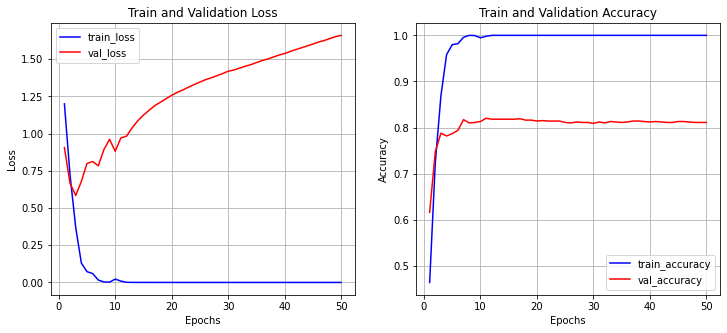

In [3]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## Submission

In [4]:
import json

def load_test_df():
    with open("data/test.json") as file:
        test_json = json.load(file)
    
    file_names = []
    conversations = []
    for file_name in test_json:
        conversation = test_json[file_name]["text"]

        file_names.append(file_name)
        conversations.append(conversation)
        
    return pd.DataFrame({"file_name": file_names, "conversation": conversations})
    
test_df = load_test_df()
test_df

,file_name,conversation
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [5]:
import numpy as np

# Tokenization
test_sequences = tokenizer.texts_to_sequences(test_df["conversation"])
test_sequences = pad_sequences(test_sequences, padding="post", maxlen=SEQ_LEN)

# Prediction
model = tf.keras.models.load_model(MODEL_PATH)
predictions_prob = model.predict(test_sequences)
predictions = np.argmax(predictions_prob, axis=1)
test_df["class"] = predictions
test_df["class_str"] = test_df["class"].apply(lambda x: label_to_class[x])
test_df

,file_name,conversation,class,class_str
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,3,기타 괴롭힘 대화
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,2,직장 내 괴롭힘 대화
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2,직장 내 괴롭힘 대화
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,2,직장 내 괴롭힘 대화
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,2,직장 내 괴롭힘 대화
...,...,...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,2,직장 내 괴롭힘 대화
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,2,직장 내 괴롭힘 대화
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,1,갈취 대화
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,2,직장 내 괴롭힘 대화


In [8]:
submission_df = pd.read_csv("data/submission.csv")
test_submission_df = (submission_df
                      .merge(test_df[["file_name", "class"]], on="file_name")
                      .drop(columns=["class_x"])
                      .rename(columns={"class_y": "class"}))
test_submission_df.to_csv(f"submissions/baseline_{NOW}.csv", index=False)
pd.read_csv(f"submissions/baseline_{NOW}.csv")

,file_name,class
0,t_000,3
1,t_001,2
2,t_002,2
3,t_004,2
4,t_005,0
...,...,...
395,t_495,2
396,t_496,2
397,t_497,1
398,t_498,2
